In [2]:
import os 
import copy 
import numpy as np
np.set_printoptions(suppress=True, precision=3)

from scipy.spatial.transform import Rotation as R

import symforce 
symforce.set_log_level("ERROR")
print(f"symforce uses {symforce.get_symbolic_api()} as backend")
from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.values import Values
from symforce import typing as sfT

%matplotlib notebook 
import matplotlib.pyplot as plt

import gtsam
from gtsam.utils import plot



symforce uses symengine as backend


<IPython.core.display.Javascript object>


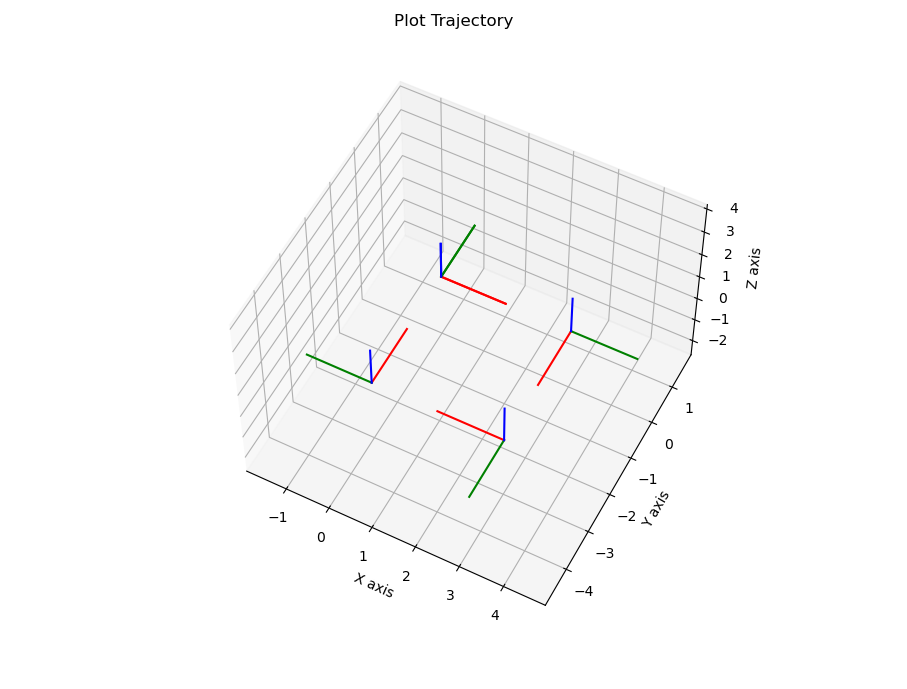

In [4]:


### generate a mini graph having 4 poses

# helper funcs 
def move(prev_pose, x_meter=1.0, yaw_deg=90):
    # input: assume prev_pose is 4x4 SE(3) matrix 
    # output: SE(3), the moved (transformed) pose 

    def rpy2mat(rpy, deg=True):
        return R.from_euler('xyz', rpy, degrees=deg).as_matrix()

    def movement():
        movement_yaw = yaw_deg # deg, means turn left
        movement_SO3 = rpy2mat(np.array([0, 0, movement_yaw]))

        movement_trans = [x_meter, 0.0, 0.0] # x means moving direction (forward)

        movement = np.eye(4) # SE(3)
        movement[:3, :3] = movement_SO3
        movement[:3, -1] = movement_trans
        
        return movement 
    
    tf = movement()
    next_pose = prev_pose @ tf

    return next_pose, tf

# initial pose 
pose_start = np.eye(4)

# evolv poses 
curr_pose = pose_start
poses_gt = [curr_pose] # poses to be appended to this list 

n = 4
num_poses = n + 1
yaw_onestep = 180 * (1 - (n-2)/n) # to generate a regular polygon trajecotry 

odoms_gt = []
for ii in range(num_poses-1):
    moved_pose, odom = move(curr_pose, x_meter=3.0, yaw_deg=-yaw_onestep)
    poses_gt.append(moved_pose)
    odoms_gt.append(odom)
    
    curr_pose = moved_pose

# generate loop factor (between the start and the end poses)
loops_gt = [] 
loops_indexes = [(num_poses-1, 0)] # only a single loop chaining. 
# loops_indexes = [(num_poses-1, 0), (1, 4), (2, 4), (0, 3)]
for loops_index_pair in loops_indexes:
    idx_from = loops_index_pair[0]
    idx_to = loops_index_pair[1]
    loop_gt = np.linalg.inv(poses_gt[idx_from]) @ poses_gt[idx_to]
    loops_gt.append(loop_gt)

# debug 
if 0:
    _ = [print(f"The generated GT pose of idx {i} is:\n {pose}") for i, pose in enumerate(poses_gt)]    

    print("")
    _ = [print(f"The applied GT control input between idx {i} and {i+1} is:\n {odom}") \
         for i, odom in enumerate(odoms_gt)]    

    print("")
    _ = [print(f"The GT loop closure factors between idx {idx[0]} and {idx[1]} is:\n {loop}") \
         for _, (idx, loop) in enumerate(zip(loops_indexes, loops_gt))]   

### draw the gt poses 
result = gtsam.Values()
for ii, pose_gt in enumerate(poses_gt):
    SE3 = np.eye(4)
    SE3[:3, :3] = pose_gt[:3, :3]
    SE3[:3, -1] = pose_gt[:3, -1]
    result.insert(ii, gtsam.Pose3(SE3))

fig_idx = 1
plot.plot_trajectory(fig_idx, result, scale=1.5)
plot.set_axes_equal(True)
plt.show()



In [5]:
# error models (cost functions)
eps = 0.000001

def prior_residual(
        pose    : sf.Pose3, 
        pose_prior: sf.Pose3,
        diagonal_sigmas: sf.V6 
    ) -> sf.V6:

    tangent_error = pose.local_coordinates(pose_prior, epsilon=eps)
    return sfT.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

def odometry_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3,
        diagonal_sigmas: sf.V6,
    ) -> sf.V6:
    
    # The original reference of the below lines 
    #  - see https://github.com/symforce-org/symforce/blob/main/symforce/examples/robot_3d_localization/robot_3d_localization.py#L63
    movement_predicted = pose_prev.inverse() * pose_next
    tangent_error = movement_predicted.local_coordinates(movement, epsilon=eps)
    return sfT.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

def loop_residual(
        pose_prev: sf.Pose3, 
        pose_next: sf.Pose3, 
        movement : sf.Pose3,
        diagonal_sigmas: sf.V6,
    ) -> sf.V6:

    return odometry_residual(pose_prev, pose_next, movement, diagonal_sigmas)
    


In [6]:
## generate factors
def np2sf_batch(mats_np, use_trans_noise=False):

    def SE3_np2sf(mat: np.ndarray, use_trans_noise=False):
        mat_sf = sf.Pose3.identity()
        mat_sf.t = sf.V3(mat[:3, -1])
        mat_sf.R = sf.Rot3.from_rotation_matrix(mat[:3, :3], epsilon=sf.numeric_epsilon)

        perturb_alpha = 1.0
        if not use_trans_noise:
            perturb_alpha = 0.0 

        perturb = perturb_alpha * np.array([0.05, 0.05, 0.05, 0.2, 0.2, 0.02])
        tangent_perturbation = np.random.normal(size=6) * perturb
        return mat_sf.retract(tangent_perturbation, epsilon=sf.numeric_epsilon)

    mats_sf = []
    for mat in mats_np:
        mats_sf.append(SE3_np2sf(mat, use_trans_noise=use_trans_noise))    
        
    return mats_sf

poses_prior = np2sf_batch(poses_gt, use_trans_noise=False)
odoms_obs   = np2sf_batch(odoms_gt, use_trans_noise=True)
loops_obs   = np2sf_batch(loops_gt, use_trans_noise=False)

## noises 
prior_diagonal_sigmas = np.array([0.001, 0.001, 0.001, 0.01, 0.01, 0.01]) * 0.001
odometry_diagonal_sigmas = np.array([0.05, 0.05, 0.05, 0.1, 0.1, 0.1]) 
loop_diagonal_sigmas = odometry_diagonal_sigmas * 0.1

## initial values (note that using identity cannot converges, thus perturb the prior value and use it.)
initial_poses = []
for ii, pose_prior in enumerate(poses_prior):
    tangent_perturbation = np.random.normal(size=6) * 5*np.array([0.05, 0.05, 0.05, 0.2, 0.2, 0.2])
    initial_pose = pose_prior.retract(tangent_perturbation)
    initial_poses.append(initial_pose)
    
    trans_init_guess = np.array(initial_pose.t.transpose()).astype('float')
    trans_gt = np.array(pose_prior.t.transpose()).astype('float')
    print(f"initial location at {ii} is {trans_init_guess} (true is: {trans_gt})")

initial_values = Values(
    # poses=[sf.Pose3.identity()] * num_poses, # may not converge.
    poses=initial_poses,
    
    poses_prior=poses_prior,
    prior_diagonal_sigmas=prior_diagonal_sigmas,

    odoms=odoms_obs,
    odometry_diagonal_sigmas=odometry_diagonal_sigmas,
    
    loops=loops_obs,
    loop_diagonal_sigmas=loop_diagonal_sigmas,
)


initial location at 0 is [-1.325 -1.9    0.137] (true is: [0. 0. 0.])
initial location at 1 is [ 3.053 -0.646  0.948] (true is: [3. 0. 0.])
initial location at 2 is [ 2.622 -1.511  1.76 ] (true is: [ 3. -3.  0.])
initial location at 3 is [-2.186 -2.008 -2.463] (true is: [ 0. -3.  0.])
initial location at 4 is [ 0.685  1.37  -0.78 ] (true is: [-0. -0.  0.])
